# 1) Install dependencies


In [53]:
!pip install -q "anomalib[full]" opencv-python scikit-learn matplotlib seaborn pandas

# 2) Imports


In [54]:
import os
import glob
import shutil
import zipfile

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl

from sklearn.metrics import roc_auc_score, roc_curve, f1_score

from lightning.pytorch.callbacks import Callback

from anomalib.models import Patchcore


# 3) Dataset unpacking and AD-style reorganization

In [55]:
zip_path = "/content/archive.zip"          # uploaded zip from Kaggle of dataset
tmp_extract = "/content/_tmp_poke_extract"
POKE_AD_ROOT = "/content/pokemon_ad"       # AD (Anomaly Detection) style root

# Basic checks
print("Zip exists:", os.path.exists(zip_path))
if os.path.exists(zip_path):
    print("Is dir:", os.path.isdir(zip_path))
    print("Size (bytes):", os.path.getsize(zip_path))
    print("zipfile.is_zipfile:", zipfile.is_zipfile(zip_path))

# Clean previous data
if os.path.isdir(POKE_AD_ROOT):
    shutil.rmtree(POKE_AD_ROOT)
if os.path.isdir(tmp_extract):
    shutil.rmtree(tmp_extract)
os.makedirs(tmp_extract, exist_ok=True)

# 1. Extract archive.zip to temporary folder
print(f"Extracting {zip_path} ...")
with zipfile.ZipFile(zip_path, mode="r") as zf:
    zf.extractall(tmp_extract)

# 2. Locate dataset root (folder containing train/, test/, train_labels.csv, test_labels.csv)
RAW_ROOT = None
for root, dirs, files in os.walk(tmp_extract):
    dirset = set(dirs)
    fileset = set(files)
    if {"train", "test"}.issubset(dirset) and {"train_labels.csv", "test_labels.csv"}.issubset(fileset):
        RAW_ROOT = root
        break

if RAW_ROOT is None:
    raise RuntimeError(
        f"Error: Could not find dataset folder with 'train', 'test', "
        f"'train_labels.csv' and 'test_labels.csv' inside the archive.\n"
        f"Scanned under: {tmp_extract}"
    )

print("RAW_ROOT:", RAW_ROOT)
print("Subdirs at RAW_ROOT:", os.listdir(RAW_ROOT))

# 3. Read label CSVs (id column as string; label: 0=fake, 1=real)
train_labels_path = os.path.join(RAW_ROOT, "train_labels.csv")
test_labels_path = os.path.join(RAW_ROOT, "test_labels.csv")

train_df = pd.read_csv(train_labels_path, dtype={"id": str, "label": int})
test_df = pd.read_csv(test_labels_path, dtype={"id": str, "label": int})

print("Train label head:")
print(train_df.head())
print("Test label head:")
print(test_df.head())

# 4. Prepare AD-style directory structure
# - train/real: subset of real training cards (normal training data)
# - val/real: held-out real training cards (validation normals)
# - val/fake: all fake training cards (validation anomalies)
# - test/real, test/fake: held-out evaluation split from original test set

os.makedirs(os.path.join(POKE_AD_ROOT, "train", "real"), exist_ok=True)
os.makedirs(os.path.join(POKE_AD_ROOT, "val", "real"), exist_ok=True)
os.makedirs(os.path.join(POKE_AD_ROOT, "val", "fake"), exist_ok=True)
os.makedirs(os.path.join(POKE_AD_ROOT, "test", "real"), exist_ok=True)
os.makedirs(os.path.join(POKE_AD_ROOT, "test", "fake"), exist_ok=True)

def resolve_image_path(split: str, img_id_str: str):
    """
    Given split ('train' or 'test') and an ID string from CSV, find the corresponding image path.
    Tries both zero-padded and non-padded names, and common extensions.
    """
    candidates = [img_id_str, img_id_str.lstrip("0")]
    exts = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]

    for base in candidates:
        if not base:
            continue
        for ext in exts:
            candidate = os.path.join(RAW_ROOT, split, base + ext)
            if os.path.exists(candidate):
                return candidate

    raise FileNotFoundError(
        f"Could not find image for id='{img_id_str}' in split='{split}'. "
        f"Tried candidates: {candidates} with extensions {exts}"
    )

# 5. Populate AD-style directories
train_real_count = 0
val_real_count = 0
val_fake_count = 0
test_real_count = 0
test_fake_count = 0

# split real training cards into train/real and val/real (disjoint)
real_train_ids = sorted(train_df.loc[train_df["label"] == 1, "id"].tolist())
fake_train_ids = sorted(train_df.loc[train_df["label"] == 0, "id"].tolist())

n_real = len(real_train_ids)
if n_real == 0:
    raise RuntimeError("No real cards found in training labels.")

# use 80% real for training, 20% for validation (at least 1 in each split if possible)
val_real_size = max(1, n_real // 5)
split_idx = n_real - val_real_size
train_real_ids_split = set(real_train_ids[:split_idx])
val_real_ids_split = set(real_train_ids[split_idx:])

print(f"Total real train cards: {n_real}")
print(f"Train normals (real): {len(train_real_ids_split)}")
print(f"Val normals (real): {len(val_real_ids_split)}")
print(f"Val anomalies (fake): {len(fake_train_ids)}")

# Training / validation from train_df
for _, row in train_df.iterrows():
    img_id = row["id"]
    label = int(row["label"])  # 0=fake, 1=real
    src = resolve_image_path("train", img_id)

    if label == 1:
        if img_id in train_real_ids_split:
            dst_dir = os.path.join(POKE_AD_ROOT, "train", "real")
            train_real_count += 1
        else:
            dst_dir = os.path.join(POKE_AD_ROOT, "val", "real")
            val_real_count += 1
    else:
        dst_dir = os.path.join(POKE_AD_ROOT, "val", "fake")
        val_fake_count += 1

    dst = os.path.join(dst_dir, os.path.basename(src))
    shutil.copy2(src, dst)

# Testing from test_df
for _, row in test_df.iterrows():
    img_id = row["id"]
    label = int(row["label"])  # 0=fake, 1=real

    src = resolve_image_path("test", img_id)
    if label == 1:
        dst_dir = os.path.join(POKE_AD_ROOT, "test", "real")
        test_real_count += 1
    else:
        dst_dir = os.path.join(POKE_AD_ROOT, "test", "fake")
        test_fake_count += 1

    dst = os.path.join(dst_dir, os.path.basename(src))
    shutil.copy2(src, dst)

# 6. Cleanup temp extraction
if os.path.isdir(tmp_extract):
    shutil.rmtree(tmp_extract)

print("POKE_AD_ROOT:", POKE_AD_ROOT)
print("Train/real count:", train_real_count)
print("Val/real count:", val_real_count)
print("Val/fake count:", val_fake_count)
print("Test/real count:", test_real_count)
print("Test/fake count:", test_fake_count)
print("Train subdirs:", os.listdir(os.path.join(POKE_AD_ROOT, "train")))
print("Val subdirs:", os.listdir(os.path.join(POKE_AD_ROOT, "val")))
print("Test subdirs:", os.listdir(os.path.join(POKE_AD_ROOT, "test")))


Zip exists: True
Is dir: False
Size (bytes): 11505572
zipfile.is_zipfile: True
Extracting /content/archive.zip ...
RAW_ROOT: /content/_tmp_poke_extract
Subdirs at RAW_ROOT: ['test', 'test_labels.csv', 'train', 'train_labels.csv']
Train label head:
      id  label
0  00001      0
1  00002      0
2  00003      0
3  00004      0
4  00005      0
Test label head:
      id  label
0  00374      0
1  00375      0
2  00376      0
3  00377      0
4  00378      0
Total real train cards: 250
Train normals (real): 200
Val normals (real): 50
Val anomalies (fake): 123
POKE_AD_ROOT: /content/pokemon_ad
Train/real count: 200
Val/real count: 50
Val/fake count: 123
Test/real count: 50
Test/fake count: 28
Train subdirs: ['real']
Val subdirs: ['real', 'fake']
Test subdirs: ['real', 'fake']


# 4) Configuration


In [56]:
TRAIN_NORMAL_DIR = os.path.join(POKE_AD_ROOT, "train", "real")
VAL_NORMAL_DIR = TRAIN_NORMAL_DIR
VAL_ANOM_DIRS = [os.path.join(POKE_AD_ROOT, "val", "fake")]
TEST_NORMAL_DIR = os.path.join(POKE_AD_ROOT, "test", "real")
TEST_ANOM_DIRS = [os.path.join(POKE_AD_ROOT, "test", "fake")]

MODEL_NAME = "patchcore"

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_WORKERS = 2
MAX_EPOCHS = 1

SEED = 42
pl.seed_everything(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("TRAIN_NORMAL_DIR:", TRAIN_NORMAL_DIR)
print("VAL_NORMAL_DIR:", VAL_NORMAL_DIR)
print("VAL_ANOM_DIRS:", VAL_ANOM_DIRS)
print("TEST_NORMAL_DIR:", TEST_NORMAL_DIR)
print("TEST_ANOM_DIRS:", TEST_ANOM_DIRS)
print("DEVICE:", DEVICE)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


TRAIN_NORMAL_DIR: /content/pokemon_ad/train/real
VAL_NORMAL_DIR: /content/pokemon_ad/train/real
VAL_ANOM_DIRS: ['/content/pokemon_ad/val/fake']
TEST_NORMAL_DIR: /content/pokemon_ad/test/real
TEST_ANOM_DIRS: ['/content/pokemon_ad/test/fake']
DEVICE: cuda


# 5) Preprocessing utilities (RGB + ImageNet normalization)

In [57]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(path):
    """
    Minimal preprocessing aligned with ImageNet statistics:
      - Read BGR, convert to RGB
      - Resize to IMAGE_SIZE
      - Convert to float32 in [0, 1]
      - Normalize with ImageNet mean/std
      - Return 3xHxW tensor
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

    rgb = rgb.astype(np.float32) / 255.0
    rgb = (rgb - IMAGENET_MEAN[None, None, :]) / IMAGENET_STD[None, None, :]
    rgb = np.transpose(rgb, (2, 0, 1)) # (C, H, W)
    return torch.from_numpy(rgb)

def visualize_preprocess(path):
    """
    Visualize the preprocessed image (de-normalized to [0,1] RGB).
    """
    tensor = preprocess_image(path) # (3, H, W)
    arr = tensor.numpy()
    arr = np.transpose(arr, (1, 2, 0)) # (H, W, C)

    rgb = arr * IMAGENET_STD[None, None, :] + IMAGENET_MEAN[None, None, :]
    rgb = np.clip(rgb, 0.0, 1.0)

    plt.figure(figsize=(4, 4))
    plt.imshow(rgb)
    plt.title("Preprocessed (denorm)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 6) Dataset and DataModule

In [58]:
from dataclasses import dataclass
from typing import List, Any, Union

@dataclass
class EggBatch:
    image: torch.Tensor # (B, 3, H, W)
    label: torch.Tensor # (B,)
    mask: torch.Tensor # (B, 1, H, W)
    gt_mask: torch.Tensor # (B, 1, H, W)
    image_path: List[str] # length B

    def update(self, **kwargs: Any):
        for k, v in kwargs.items():
            setattr(self, k, v)
        return self

def egg_collate_fn(batch_list):
    images = torch.stack([b["image"] for b in batch_list]) # (B, 3, H, W)
    masks = torch.stack([b["mask"] for b in batch_list]) # (B, 1, H, W)
    labels = torch.tensor([b["label"] for b in batch_list], dtype=torch.long)
    image_paths = [b["image_path"] for b in batch_list]

    return EggBatch(
        image=images,
        label=labels,
        mask=masks,
        gt_mask=masks,
        image_path=image_paths,
    )

class EggDataset(Dataset):
    def __init__(self, normal_dir: Union[str, List[str], None],
                 cracked_dir: Union[str, List[str], None] = None,
                 transform=None):
        """
        Dataset for anomaly detection.
        If cracked_dir is None:
            - Only normal samples (label = 0) are loaded.
        Otherwise:
            - Normal samples are labeled 0.
            - Anomaly samples are labeled 1.
        """
        self.transform = transform
        self.samples = []

        # normal images
        if normal_dir is not None:
            if isinstance(normal_dir, (list, tuple)):
                norm_dirs = normal_dir
            else:
                norm_dirs = [normal_dir]

            for nd in norm_dirs:
                if not os.path.isdir(nd):
                    continue
                norm_paths = sorted(
                    glob.glob(os.path.join(nd, "*.jpg")) +
                    glob.glob(os.path.join(nd, "*.jpeg")) +
                    glob.glob(os.path.join(nd, "*.png")) +
                    glob.glob(os.path.join(nd, "*.JPG")) +
                    glob.glob(os.path.join(nd, "*.JPEG")) +
                    glob.glob(os.path.join(nd, "*.PNG"))
                )
                for p in norm_paths:
                    self.samples.append((p, 0))

        # Anomalous images
        if cracked_dir is not None:
            if isinstance(cracked_dir, (list, tuple)):
                crack_dirs = cracked_dir
            else:
                crack_dirs = [cracked_dir]

            for cd in crack_dirs:
                if not os.path.isdir(cd):
                    continue
                crack_paths = sorted(
                    glob.glob(os.path.join(cd, "*.jpg")) +
                    glob.glob(os.path.join(cd, "*.jpeg")) +
                    glob.glob(os.path.join(cd, "*.png")) +
                    glob.glob(os.path.join(cd, "*.JPG")) +
                    glob.glob(os.path.join(cd, "*.JPEG")) +
                    glob.glob(os.path.join(cd, "*.PNG"))
                )
                for p in crack_paths:
                    self.samples.append((p, 1))

        if len(self.samples) == 0:
            raise RuntimeError(
                f"No images found for normal_dir={normal_dir} cracked_dir={cracked_dir}"
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        image = self.transform(path) if self.transform is not None else preprocess_image(path)
        if not torch.is_tensor(image):
            image = torch.as_tensor(image, dtype=torch.float32)
        image = image.float()  # (C, H, W)

        mask = torch.zeros(1, IMAGE_SIZE[1], IMAGE_SIZE[0], dtype=torch.uint8)
        h, w = IMAGE_SIZE[1], IMAGE_SIZE[0]

        if label == 1:
            # mark entire image as anomalous for fake cards
            mask = torch.ones(1, h, w, dtype=torch.uint8)
        else:
            # normal cards have no anomalous pixels
            mask = torch.zeros(1, h, w, dtype=torch.uint8)

        return {
            "image": image,
            "label": torch.tensor(label, dtype=torch.int64),
            "mask": mask,
            "image_path": path,
        }

class EggDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_dir,
                 val_normal_dir,
                 val_cracked_dir,
                 test_normal_dir,
                 test_cracked_dir,
                 batch_size=8,
                 num_workers=2):
        """
        DataModule for anomaly detection:
        - Train on normal samples only: train_dir (label = 0).
        - Validate on mixed normal/anomalous from training split:
            val_normal_dir (0), val_cracked_dir (1).
        - Test on mixed normal/anomalous from held-out test split:
            test_normal_dir (0), test_cracked_dir (1).
        """
        super().__init__()
        self.train_dir = train_dir
        self.val_normal_dir = val_normal_dir
        self.val_cracked_dir = val_cracked_dir
        self.test_normal_dir = test_normal_dir
        self.test_cracked_dir = test_cracked_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage=None):
        if stage is None or stage == "fit":
            self.train_dataset = EggDataset(
                normal_dir=self.train_dir,
                cracked_dir=None,
                transform=preprocess_image,
            )
            self.val_dataset = EggDataset(
                normal_dir=self.val_normal_dir,
                cracked_dir=self.val_cracked_dir,
                transform=preprocess_image,
            )

        if stage is None or stage in ("test", "predict"):
            self.test_dataset = EggDataset(
                normal_dir=self.test_normal_dir,
                cracked_dir=self.test_cracked_dir,
                transform=preprocess_image,
            )

    def train_dataloader(self):
        if self.train_dataset is None:
            self.setup(stage="fit")
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=False,
            collate_fn=egg_collate_fn,
        )

    def val_dataloader(self):
        if self.val_dataset is None:
            self.setup(stage="fit")
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            collate_fn=egg_collate_fn,
        )

    def test_dataloader(self):
        if self.test_dataset is None:
            self.setup(stage="test")
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
        )


# 7) Instantiate DataModule and visualize a sample


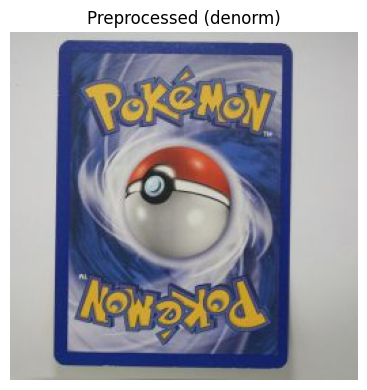

In [59]:
data_module = EggDataModule(
    train_dir=TRAIN_NORMAL_DIR,
    val_normal_dir=VAL_NORMAL_DIR,
    val_cracked_dir=VAL_ANOM_DIRS,
    test_normal_dir=TEST_NORMAL_DIR,
    test_cracked_dir=TEST_ANOM_DIRS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

if os.path.isdir(TRAIN_NORMAL_DIR):
    sample_paths = sorted(
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.jpg")) +
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.jpeg")) +
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.png")) +
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.JPG")) +
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.JPEG")) +
        glob.glob(os.path.join(TRAIN_NORMAL_DIR, "*.PNG"))
    )
    if sample_paths:
        visualize_preprocess(sample_paths[0])
    else:
        print(f"No training images found in {TRAIN_NORMAL_DIR}.")
else:
    print(f"Training directory {TRAIN_NORMAL_DIR} does not exist.")


# 8) Model definition (PatchCore) and training

In [60]:
class DebugValidationCallback(Callback):
    def on_validation_epoch_start(self, trainer, pl_module):
        # single, simple stdout print
        print("[DEBUG] validation epoch START")

    def on_validation_epoch_end(self, trainer, pl_module):
        print("[DEBUG] validation epoch END")

data_module.setup("fit")

for batch in data_module.train_dataloader():
    print("Sample batch type:", type(batch))
    print("batch.image.shape:", batch.image.shape)
    print("batch.image.device:", batch.image.device)
    break

model = Patchcore(
    backbone="wide_resnet50_2",
    layers=["layer2", "layer3", "layer4"],
    pre_trained=True,
    coreset_sampling_ratio=0.1,
    num_neighbors=9,
    pre_processor=False,
)


debug_val_cb = DebugValidationCallback()

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if DEVICE == "cuda" else "cpu",
    devices=1,
    enable_progress_bar=False,
    log_every_n_steps=1,
    num_sanity_val_steps=0,
    callbacks=[debug_val_cb],
)

pl.seed_everything(SEED)
trainer.fit(model, datamodule=data_module)

print("VAL_NORMAL_DIR:", VAL_NORMAL_DIR)
print("VAL_ANOM_DIRS:", VAL_ANOM_DIRS)
print("TEST_NORMAL_DIR:", TEST_NORMAL_DIR)
print("TEST_ANOM_DIRS:", TEST_ANOM_DIRS)
print("Val samples total:", len(data_module.val_dataset.samples))
print("Val normals:", sum(label == 0 for _, label in data_module.val_dataset.samples))
print("Val anomalies:", sum(label == 1 for _, label in data_module.val_dataset.samples))

batch_test = next(iter(data_module.test_dataloader()))
x = batch_test["image"].to(next(model.parameters()).device)

with torch.no_grad():
    out = model.model(x)

print("Model output type:", type(out))
if hasattr(out, "keys"):
    print("Output keys:", out.keys())


Sample batch type: <class '__main__.EggBatch'>
batch.image.shape: torch.Size([8, 3, 256, 256])
batch.image.device: cpu


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ post_processor │ PostProcessor  │      0 │ train │     0 │
│ 1 │ evaluator      │ Evaluator      │      0 │ train │     0 │
│ 2 │ model          │ PatchcoreModel │ 66.8 M │ train │     0 │
└───┴────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 66.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 66.8 M                                                                                               
Total estimated model params size (MB): 267                                                                        
Modules in train mode: 16                                                                                          
Modules in eval mode: 214                                                                                          
Total FLOPs: 0

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 214 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
Selecting Coreset Indices.: 100%|██████████| 20480/20480 [00:13<00:00, 1514.14it/s]


[DEBUG] validation epoch START
[DEBUG] validation epoch END


INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


VAL_NORMAL_DIR: /content/pokemon_ad/train/real
VAL_ANOM_DIRS: ['/content/pokemon_ad/val/fake']
TEST_NORMAL_DIR: /content/pokemon_ad/test/real
TEST_ANOM_DIRS: ['/content/pokemon_ad/test/fake']
Val samples total: 323
Val normals: 200
Val anomalies: 123
Model output type: <class 'torch.Tensor'>


# 9) Inference / Prediction and Metrics on validation set + threshold selection

Validation samples: 173
Validation normals: 50
Validation anomalies: 123
Validation AUC: 0.9540
Best validation threshold (Youden J): 28.1727
Validation F1 at best threshold: 0.9520


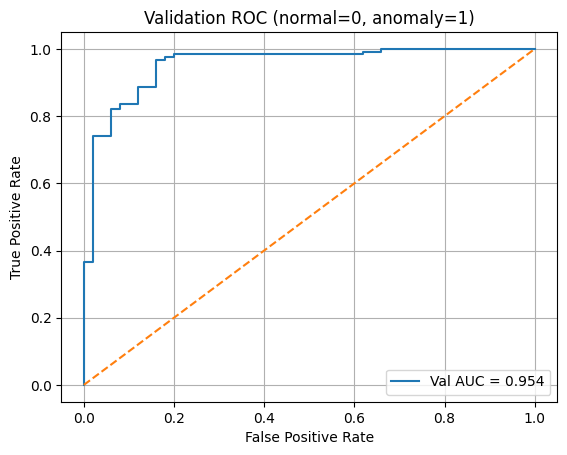

In [61]:
model.eval()
device = next(model.parameters()).device

# use the held-out validation split:
VAL_NORMAL_DIR = os.path.join(POKE_AD_ROOT, "val", "real")
VAL_ANOM_DIRS = [os.path.join(POKE_AD_ROOT, "val", "fake")]

val_dataset = EggDataset(
    normal_dir=VAL_NORMAL_DIR,
    cracked_dir=VAL_ANOM_DIRS,
    transform=preprocess_image,
)

# validation loader with EggBatch collate
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=egg_collate_fn,
    drop_last=False,
)

val_scores = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        images = batch.image.to(device)
        out = model.model(images) # InferenceBatch
        scores = out.pred_score # (B, 1)
        scores = scores.detach().cpu().numpy().reshape(-1)
        labels_batch = batch.label.detach().cpu().numpy().astype(np.int32)

        val_scores.extend(scores.tolist())
        val_labels.extend(labels_batch.tolist())

val_scores = np.asarray(val_scores, dtype=np.float32)
val_labels = np.asarray(val_labels, dtype=np.int32)

print(f"Validation samples: {len(val_scores)}")
print(f"Validation normals: {(val_labels == 0).sum()}")
print(f"Validation anomalies: {(val_labels == 1).sum()}")

if len(np.unique(val_labels)) < 2:
    print("Validation has only one class; cannot compute a threshold from ROC.")
    best_thr = None
else:
    fpr_val, tpr_val, thr_val = roc_curve(val_labels, val_scores)
    best_idx = np.argmax(tpr_val - fpr_val)  # Youden's J
    best_thr = thr_val[best_idx]
    val_auc = roc_auc_score(val_labels, val_scores)
    val_preds = (val_scores >= best_thr).astype(np.int32)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Best validation threshold (Youden J): {best_thr:.4f}")
    print(f"Validation F1 at best threshold: {val_f1:.4f}")

    plt.figure()
    plt.plot(fpr_val, tpr_val, label=f"Val AUC = {val_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Validation ROC (normal=0, anomaly=1)")
    plt.legend()
    plt.grid(True)
    plt.show()


# 10) Inference / Prediction and Metrics on test set with validation threshold


Collected 78 test predictions.
Test AUC: 0.9500


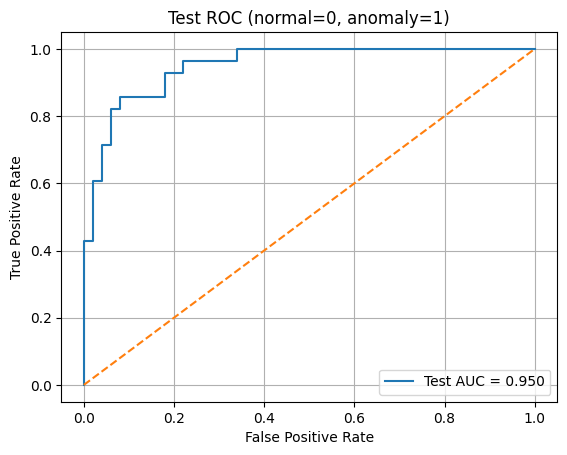

Test F1 using validation threshold 28.1727: 0.8182


In [62]:
model.eval()
device = next(model.parameters()).device

test_loader = DataLoader(
    data_module.test_dataset,
    batch_size=data_module.batch_size,
    shuffle=False,
    num_workers=data_module.num_workers,
    collate_fn=egg_collate_fn,
    drop_last=False,
)

all_image_paths = []
test_scores = []
all_anomaly_maps = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        images = batch.image.to(device)
        out = model.model(images)

        scores = out.pred_score # (B, 1)
        maps = out.anomaly_map # (B, 1, H, W) or (B, H, W)

        if maps.ndim == 3:
            maps = maps.unsqueeze(1)

        scores = scores.detach().cpu().numpy().reshape(-1)
        maps = maps.detach().cpu()

        labels_batch = batch.label.detach().cpu().numpy().astype(np.int32)

        for path, s, m, lab in zip(batch.image_path, scores, maps, labels_batch):
            all_image_paths.append(path)
            test_scores.append(float(s))
            all_anomaly_maps.append(m)
            test_labels.append(int(lab))

test_scores = np.asarray(test_scores, dtype=np.float32)
test_labels = np.asarray(test_labels, dtype=np.int32)

print(f"Collected {len(test_scores)} test predictions.")

if len(np.unique(test_labels)) < 2:
    print(f"Test labels have a single class {np.unique(test_labels)}; ROC/AUC undefined.")
else:
    fpr_test, tpr_test, thr_test = roc_curve(test_labels, test_scores)
    test_auc = roc_auc_score(test_labels, test_scores)
    print(f"Test AUC: {test_auc:.4f}")

    plt.figure()
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {test_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC (normal=0, anomaly=1)")
    plt.legend()
    plt.grid(True)
    plt.show()

    if best_thr is None:
        print("No validation threshold available; skipping F1 on test.")
    else:
        test_preds = (test_scores >= best_thr).astype(np.int32)
        test_f1 = f1_score(test_labels, test_preds)
        print(f"Test F1 using validation threshold {best_thr:.4f}: {test_f1:.4f}")



# 11) Inference / Prediction on test set with test threshold (gives theoretical best F1 with current model)

In [63]:
model.eval()
device = next(model.parameters()).device

test_loader = DataLoader(
    data_module.test_dataset,
    batch_size=data_module.batch_size,
    shuffle=False,
    num_workers=data_module.num_workers,
    collate_fn=egg_collate_fn,
    drop_last=False,
)

all_image_paths = []
all_scores = []
all_anomaly_maps = []

with torch.no_grad():
    for batch in test_loader:
        images = batch.image.to(device)
        out = model.model(images)

        scores = out.pred_score
        maps = out.anomaly_map

        if maps.ndim == 3:
            maps = maps.unsqueeze(1)

        scores = scores.detach().cpu()
        maps = maps.detach().cpu()

        for path, s, m in zip(batch.image_path, scores, maps):
            all_image_paths.append(path)
            all_scores.append(float(s.item()))
            all_anomaly_maps.append(m)

label_map = {path: label for (path, label) in data_module.test_dataset.samples}
all_labels = [label_map[p] for p in all_image_paths]
print(f"Collected {len(all_scores)} predictions for {len(all_labels)} labeled test images.")


Collected 78 predictions for 78 labeled test images.


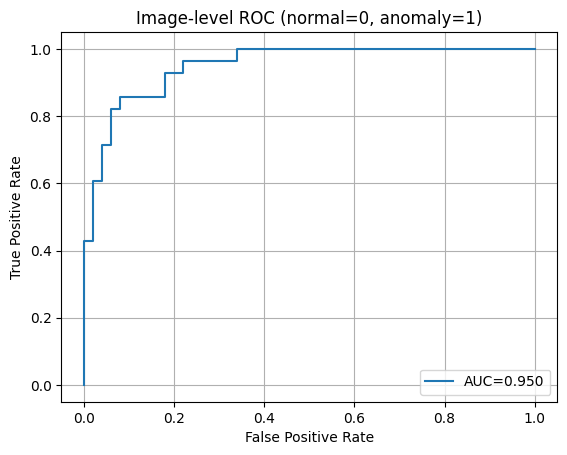

Image-level AUC: 0.9500
Best threshold (Youden J): 29.5391
Image-level F1 at best threshold: 0.8571


In [64]:
labels = np.asarray(all_labels[: len(all_scores)], dtype=np.int32)
scores = np.asarray(all_scores, dtype=np.float32)

if len(labels) != len(scores) or len(labels) < 2:
    print("Insufficient or misaligned labels/scores to compute metrics.")
else:
    unique_labels = np.unique(labels)
    if unique_labels.size < 2:
        print(f"Only one class present in labels {unique_labels}; ROC/AUC is undefined.")
    else:
        img_auc = roc_auc_score(labels, scores)
        fpr, tpr, thr = roc_curve(labels, scores)

        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={img_auc:.3f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Image-level ROC (normal=0, anomaly=1)")
        plt.legend()
        plt.grid(True)
        plt.show()

        best_idx = np.argmax(tpr - fpr)
        best_thr = thr[best_idx]

        preds = (scores >= best_thr).astype(np.int32)
        f1 = f1_score(labels, preds)

        print(f"Image-level AUC: {img_auc:.4f}")
        print(f"Best threshold (Youden J): {best_thr:.4f}")
        print(f"Image-level F1 at best threshold: {f1:.4f}")


# 12) Visualization utility (overlay anomaly map)


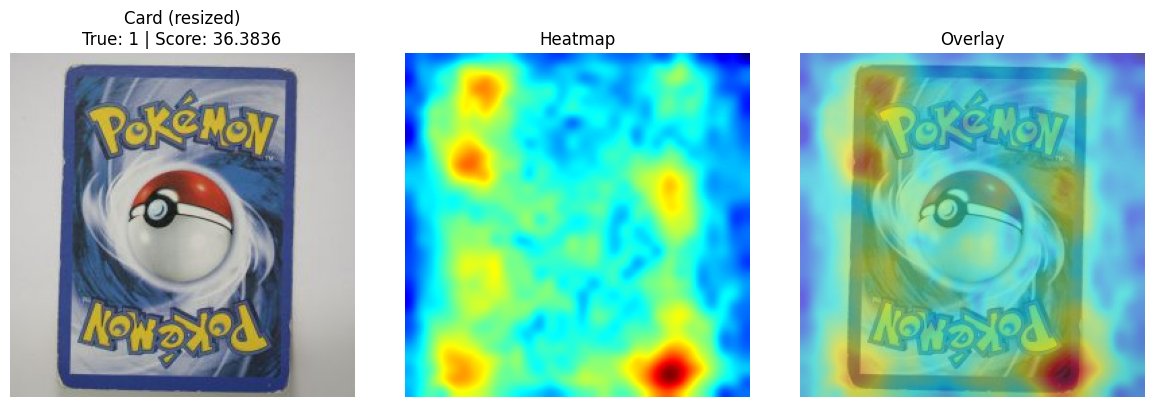

In [65]:
def overlay_heatmap_on_preprocessed(path, anomaly_map, alpha=0.5, cmap=cv2.COLORMAP_JET):
    """
    Overlay a color heatmap of the anomaly map on the resized RGB card image.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

    amap = anomaly_map
    if torch.is_tensor(amap):
        amap = amap.detach().cpu().numpy()
    amap = np.squeeze(amap)
    if amap.ndim != 2:
        raise ValueError(f"Expected 2D anomaly map, got {amap.shape}")

    H, W, _ = rgb.shape
    amap = cv2.resize(amap, (W, H))
    amap_norm = cv2.normalize(amap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    heatmap_bgr = cv2.applyColorMap(amap_norm, cmap)
    heatmap = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(rgb, 1.0 - alpha, heatmap, alpha, 0.0)
    return rgb, heatmap, overlay

def show_overlay(idx=0):
    img_path = all_image_paths[idx]
    amap = all_anomaly_maps[idx]
    true_label = all_labels[idx]
    score = all_scores[idx]

    rgb, heatmap, overlay = overlay_heatmap_on_preprocessed(img_path, amap)

    plt.figure(figsize=(12, 4))
    for i, (im, title) in enumerate(
        zip([rgb, heatmap, overlay], ["Card (resized)", "Heatmap", "Overlay"])
    ):
        plt.subplot(1, 3, i + 1)
        plt.imshow(im)
        if i == 0:
            plt.title(f"{title}\nTrue: {true_label} | Score: {score:.4f}")
        else:
            plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# example
visualization_index = 51
if len(all_image_paths) > 0:
    show_overlay(idx=min(visualization_index, len(all_image_paths) - 1))
else:
    print("No predictions available for visualization.")


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
